### Loading packages

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"

import theano

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt


### Loading data from repository:

With pandas we can do it directly from the web and with the right args we can directly tidy the data in gempy style:

In [2]:
dfs = []
for letter in 'ABCD':
    dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/'+
                           letter+'Points.csv', sep=';',
                         names=['X', 'Y', 'Z', 'surface', 'cutoff'], header=0)[::1])
## Add fault:
dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/Fault.csv',
                      names=['X', 'Y', 'Z', 'surface'], header=0, sep=';'))
surface_points = pn.concat(dfs, sort=True)
#surface_points['surface'] = surface_points['surface'].astype('str')
surface_points.reset_index(inplace=True, drop=False)
surface_points.tail()

,index,X,Y,Z,cutoff,surface
20042,88,551099.250977,7.817652e+06,-10466.863281,NaN,Claudius_fault
20043,89,551160.807495,7.817503e+06,-10356.463867,NaN,Claudius_fault
20044,90,551131.898438,7.817659e+06,-10383.323242,NaN,Claudius_fault
20045,91,551164.412476,7.817654e+06,-10299.957031,NaN,Claudius_fault
20046,92,551197.192139,7.817647e+06,-10216.820312,NaN,Claudius_fault


How many points are per surface

In [3]:
surface_points.groupby('surface').count()

,index,X,Y,Z,cutoff
surface,,,,,
0,5000,5000,5000,5000,5000
60,5000,5000,5000,5000,5000
250,5000,5000,5000,5000,5000
330,4954,4954,4954,4954,4954
Claudius_fault,93,93,93,93,0


Now we do the same with the orientations:

In [4]:
dfs = []

for surf in [0.0, 330.0]:
    o = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/Dips.csv', sep=';',
                    names=['X', 'Y', 'Z', 'G_x', 'G_y', 'G_z', '-'], header=1)

    # Orientation needs to belong to a surface. This is mainly to categorize to which series belong and to
    # use the same color
    o['surface'] = surf
    dfs.append(o)
orientations = pn.concat(dfs, sort=True)
orientations.reset_index(inplace=True, drop=False)

orientations.tail()

,index,-,G_x,G_y,G_z,X,Y,Z,surface
43,19,0.976692,0.187195,0.138165,-0.972558,550989.3105,7817210.527,-9782.967773,330.0
44,20,0.248187,-0.080561,-0.043063,-0.995819,550939.3105,7821227.309,-9958.425781,330.0
45,21,0.649480,-0.161328,0.075208,-0.984031,549276.8105,7820682.980,-9985.125977,330.0
46,22,0.050025,-0.012103,-0.153309,-0.988104,548976.8105,7820345.121,-9974.265625,330.0
47,23,0.759421,0.369490,-0.187053,-0.910213,549764.3105,7820457.738,-9901.208984,330.0


### Data initialization:

Suggested size of the axis-aligned modeling box: 
Origin: 548800 7816600 -8400
Maximum: 552500 7822000 -11010

Suggested resolution: 100m x 100m x -90m (grid size 38 x 55 x 30)

In [5]:
# Number of voxels:
np.array([38, 55, 30]).prod()

62700

In [6]:
geo_model = gp.create_model('Claudius')
# Importing the data from csv files and settign extent and resolution
geo_model = gp.init_data(geo_model, 
                         extent= [548800,552500,7816600,7822000,-11010, -8400], resolution = [38, 55, 30],
                         surface_points_df=surface_points[::5], orientations_df=orientations, surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


We are going to increase the smoothness (nugget) of the data to increase the conditional number of the matrix:

In [7]:
geo_model.modify_surface_points(geo_model.surface_points.df.index, smooth=0.1).df.tail()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
20042,551099.250977,7.817652e+06,-10466.863281,0.541549,0.350372,0.436625,Claudius_fault,Default series,5,1,0.1
20043,551160.807495,7.817503e+06,-10356.463867,0.547415,0.336161,0.447146,Claudius_fault,Default series,5,1,0.1
20044,551131.898438,7.817659e+06,-10383.323242,0.544660,0.351065,0.444586,Claudius_fault,Default series,5,1,0.1
20045,551164.412476,7.817654e+06,-10299.957031,0.547759,0.350518,0.452531,Claudius_fault,Default series,5,1,0.1
20046,551197.192139,7.817647e+06,-10216.820312,0.550882,0.349832,0.460453,Claudius_fault,Default series,5,1,0.1


Also the original poles are pointing downwards. We can change the direction by calling the following:

In [8]:
geo_model.modify_orientations(geo_model.orientations.df.index, polarity=-1).df.tail()


,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
43,550989.3105,7817210.527,-9782.967773,0.531072,0.308282,0.501798,-0.187194,-0.138164,0.972558,166.546239,53.569684,-1.0,330,Default series,4,1,0.01
44,550939.3105,7821227.309,-9958.425781,0.526307,0.691072,0.485078,0.080561,0.043063,0.995819,174.758819,241.873756,-1.0,330,Default series,4,1,0.01
45,549276.8105,7820682.980,-9985.125977,0.367875,0.639198,0.482533,0.161328,-0.075208,0.984031,169.746878,294.994025,-1.0,330,Default series,4,1,0.01
46,548976.8105,7820345.121,-9974.265625,0.339285,0.607001,0.483568,0.012103,0.153310,0.988104,171.153539,184.513861,-1.0,330,Default series,4,1,0.01
47,549764.3105,7820457.738,-9901.208984,0.414332,0.617733,0.490530,-0.369491,0.187053,0.910213,155.534803,116.850651,-1.0,330,Default series,4,1,0.01


We need an orientation per series/fault. The faults does not have orientation so the easiest is to create an orientation from the surface points availablle:

In [9]:
fault_idx = geo_model.surface_points.df.index[geo_model.surface_points.df['surface'] =='Claudius_fault']
gp.set_orientation_from_surface_points(geo_model, fault_idx).df.tail()

../../../gempy/core/data.py:1808: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
44,550939.310500,7.821227e+06,-9958.425781,0.526307,0.691072,0.485078,0.080561,0.043063,0.995819,174.758819,241.873756,-1.0,330,Default series,4,1,0.01
45,549276.810500,7.820683e+06,-9985.125977,0.367875,0.639198,0.482533,0.161328,-0.075208,0.984031,169.746878,294.994025,-1.0,330,Default series,4,1,0.01
46,548976.810500,7.820345e+06,-9974.265625,0.339285,0.607001,0.483568,0.012103,0.153310,0.988104,171.153539,184.513861,-1.0,330,Default series,4,1,0.01
47,549764.310500,7.820458e+06,-9901.208984,0.414332,0.617733,0.490530,-0.369491,0.187053,0.910213,155.534803,116.850651,-1.0,330,Default series,4,1,0.01
48,551227.945262,7.817102e+06,-10317.794134,0.553813,0.297932,0.450831,-0.929613,-0.093253,0.356543,69.111978,264.271621,1.0,Claudius_fault,Default series,5,1,0.01


Now we can see how the data looks so far:

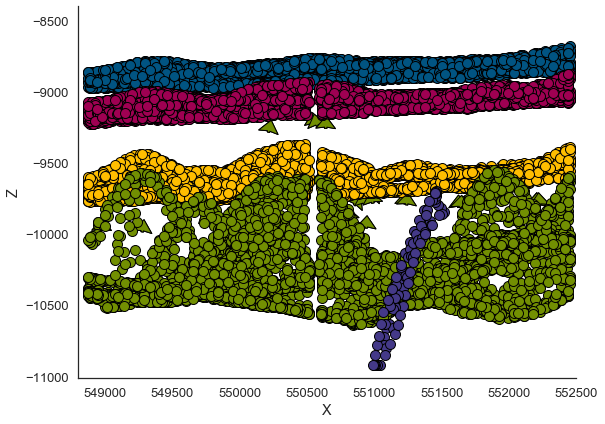

In [10]:
gp.plot.plot_data(geo_model, direction='y')

By default all surfaces belong to one unique series.

In [11]:
geo_model.surfaces

,surface,series,order_surfaces,isActive,color,id
0,0,Default series,1,True,#015482,1
1,60,Default series,2,True,#9f0052,2
2,250,Default series,3,True,#ffbe00,3
3,330,Default series,4,True,#728f02,4
4,Claudius_fault,Default series,5,True,#443988,5
5,basement,Basement,1,True,#ff3f20,6


We will need to separate with surface belong to each series:

In [12]:
stratigraphy = 'fixed'

In [13]:
if stratigraphy == 'original':
    gp.map_series_to_surfaces(geo_model, {'Fault':'Claudius_fault',
                                          'Default series':(0.0, 60.0, 250.0, 330),
                                      })
    # Ordering the events from younger to older:
    geo_model.reorder_series(['Fault', 'Default series', 'Basement'])
    
    
elif stratigraphy == 'fixed':
    gp.map_series_to_surfaces(geo_model, {'Default series':(0.0, 60.0, 250.0),
                                          'Fault':'Claudius_fault',
                                          'Uncomformity':330,
                                          })
    # Ordering the events from younger to older:
    geo_model.reorder_series(['Default series', 'Fault', 'Uncomformity', 'Basement'])

So far we did not specify which series/faults are actula faults:

In [14]:
geo_model.set_is_fault('Fault')

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault,True,False
Default series,False,False
Basement,False,False


Ordering the events from younger to older:

In [15]:
# geo_model.reorder_series(['Default series', 'Fault', 'Uncomformity', 'Basement'])

Check which series/faults are affected by other faults (rows offset columns):

In [16]:
geo_model.faults.faults_relations_df

,Fault,Default series,Basement
Fault,False,True,True
Default series,False,False,False
Basement,False,False,False


Now we are good to go:

In [17]:
gp.set_interpolation_data(geo_model, theano_optimizer='fast_run',
                          compile_theano=True)

Setting kriging parameters to their default values.
Compiling theano function...


/Users/varga/.conda/envs/gempy/lib/python3.7/site-packages/theano/gof/cc.py:968: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                       values
range                7047.13
$C_o$            1.18243e+06
drift equations    [3, 3, 3]


In [18]:
gp.compute_model(geo_model)

../../../gempy/core/solution.py:284: UserWarning: Attribute error. Using non masked marching cubesmarching_cubes_lewiner() got an unexpected keyword argument 'mask'.
  warnings.warn('Attribute error. Using non masked marching cubes' + str(e)+'.')



Lithology ids 
  [5. 5. 5. ... 2. 2. 2.] 

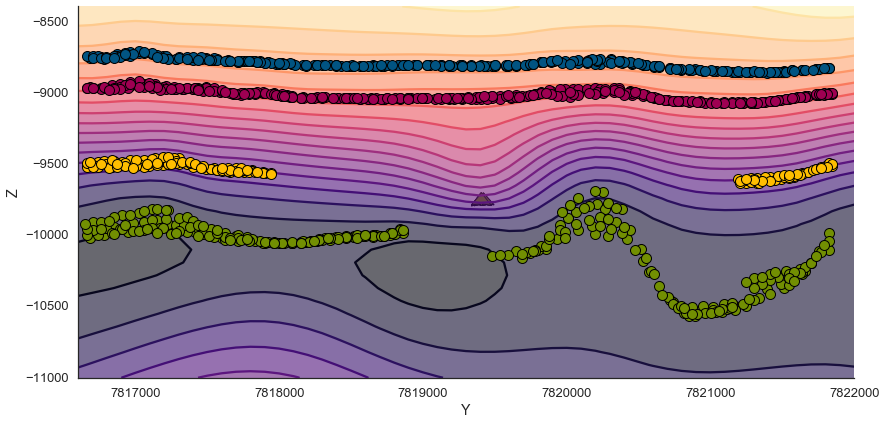

In [19]:
sect = 35
#gp.plot.plot_scalar_field(geo_model, sect, series=0, direction='x')
gp.plot.plot_scalar_field(geo_model, sect, series=1, direction='x')
#gp.plot.plot_scalar_field(geo_model, sect, series=2, direction='x')

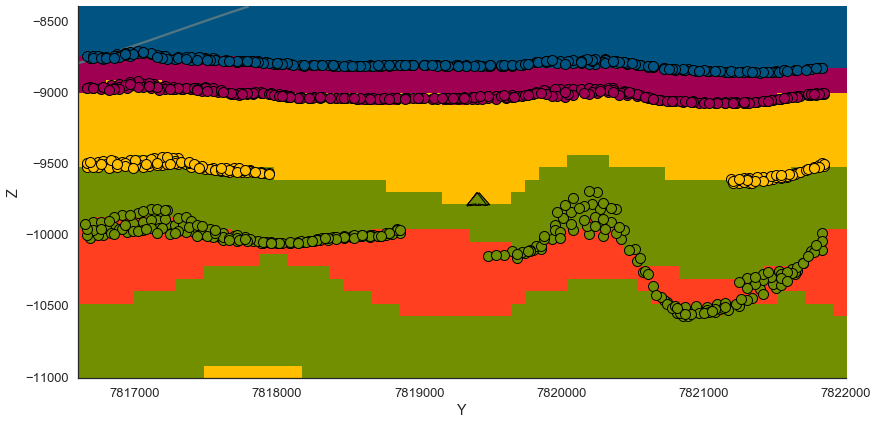

In [20]:
gp.plot.plot_section(geo_model, sect, show_data=True, direction='x')

IndexError: index 2 is out of bounds for axis 0 with size 2

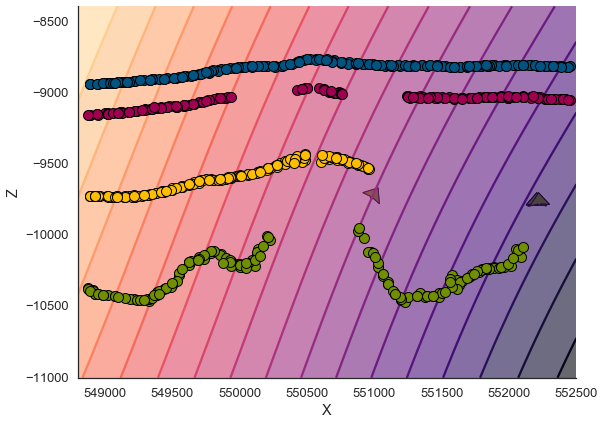

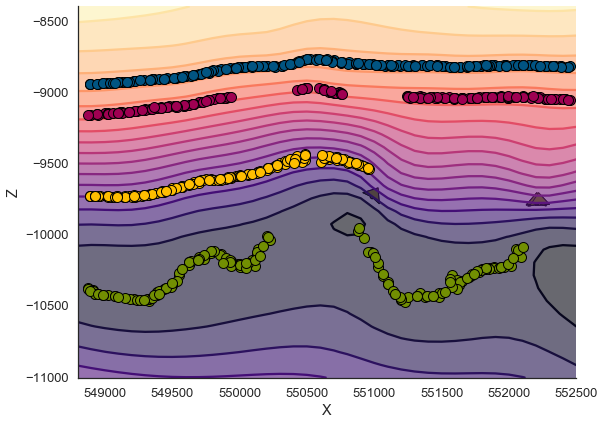

In [21]:
gp.plot.plot_scalar_field(geo_model, 28, series=0, direction='y')
gp.plot.plot_scalar_field(geo_model, 28, series=1, direction='y')
gp.plot.plot_scalar_field(geo_model, 28, series=2, direction='y')

In [ ]:
gp.plot.plot_section(geo_model, 28, show_data=True, direction='y')

In [ ]:
# gp.plot.plot_3D(geo_model, render_data=True)

![foo](Claudius.png)

### Export data:

The solution is stored in a numpy array of the following shape. Axis 0 are the scalar fields of each correspondent series/faults in the following order (except basement): 

In [ ]:
geo_model.series

For the surfaces, there are two numpy arrays, one with vertices and the other with triangles. Axis 0 is each surface in the order:

In [ ]:
geo_model.surfaces

In [ ]:
# np.save('Claudius_scalar', geo_model.solutions.scalar_field_matrix)
# np.save('Claudius_ver', geo_model.solutions.vertices)
# np.save('Claudius_edges', geo_model.solutions.edges)
# gp.plot.export_to_vtk(geo_model, 'Claudius')

## Timing:


### Fault
#### Dense 20k input, 62k voxels

- CPU Memory 8 Gb 44.9 s ± 150 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- GPU Memory 6.8 gb:
   + 2.13 s ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
           + steps __str__ = [64.56394268]
           + steps __str__ = [9927.69441126]
           + steps __str__ = [196.15202667]
       
  + 1.13 s ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
  
        + steps __str__ = [645.63943742]
        + steps __str__ = [99276.94573919]
        + steps __str__ = [1961.52029888]

## Export to gocad

In [30]:
def write_property_to_gocad_voxet(propertyfilename, propertyvalues):
    """
    This function writes a numpy array into the right format for a gocad
    voxet property file. This assumet there is a property already added to the .vo file,
    and is just updating the file.
    propertyfile - string giving the path to the file to write
    propertyvalues - numpy array nz,ny,nx ordering and in float format
    """
    propertyvalues = propertyvalues.astype('>f4') #big endian
#     array = propertyvalues.newbyteorder()
    propertyvalues.tofile(propertyfilename)

In [33]:
write_property_to_gocad_voxet('claudius_sf_gempy',
                              geo_model.solutions.scalar_field_matrix[1].reshape([38, 55, 30]).ravel('F'))